In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import cv2
from preprocess import preprocessing
#from read_mias import *
import config
from object_detector import ObjectDetector
from custom_tensor_dataset import CustomTensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
import pickle
import torch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.retinanet import RetinaNet, RetinaNet_ResNet50_FPN_V2_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
from custom_tensor_dataset import CustomTensorDataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
import random


https://debuggercafe.com/train-pytorch-retinanet-on-custom-dataset/#download-code



In [9]:
dir = os.getcwd()
info = pd.read_csv(dir +'/mias_info/labels.txt', sep = ' ', header = None)
info.columns = ['refno', 'tissue', 'class', 'severity','x','y','r']
info['severity'] = info['severity'].fillna('N')
info['image_id'] = info.refno.str.split('b', expand = True)[1].astype(int) -1
info.head()

,refno,tissue,class,severity,x,y,r,image_id
0,mdb001,G,CIRC,B,535,425,197.0,0
1,mdb002,G,CIRC,B,522,280,69.0,1
2,mdb003,D,NORM,N,NaN,NaN,NaN,2
3,mdb004,D,NORM,N,NaN,NaN,NaN,3
4,mdb005,F,CIRC,B,477,133,30.0,4


In [10]:
bm = info[info['severity'] != 'N']['refno']
notnormal = bm.tolist()

for i, name in enumerate(notnormal):
    notnormal[i] = name + '.pgm'

In [11]:
data_transform = A.Compose([
	A.Resize(512, 512),
	A.HorizontalFlip(p=0.5),
	A.Rotate(limit=15, p=1.0),
	#A.RandomBrightnessContrast(p=0.5),
	ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [12]:
from custom_tensor_dataset import list_files_walk
from retinaNetDataset import customDataset


#all_imgs = list_files_walk('mias_data/')

train, test = train_test_split(notnormal, test_size = 0.1, random_state = 42)
train, valid = train_test_split(train, test_size = 0.2, random_state = 42)

train_dataset = customDataset(imgs = train, transforms=data_transform)
test_dataset = customDataset(imgs = test, transforms = data_transform)
valid_dataset = customDataset(imgs = valid, transforms = data_transform)
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size = config.BATCH_SIZE,
                                          shuffle = True,
                                          collate_fn = collate_fn)

valid_dataloader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size = config.BATCH_SIZE,
                                          shuffle = False,
                                          collate_fn = collate_fn)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size = config.BATCH_SIZE,
                                          shuffle = False,
                                          collate_fn = collate_fn)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
for imgs, annotations in train_dataloader:
    imgs = list(img.to(device) for img in imgs)
    print(imgs[0].dtype)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

cpu
torch.float32
[{'boxes': tensor([[141.1539, 200.6634, 148.3239, 207.8334],
        [152.1913, 221.9521, 177.7985, 247.5593],
        [263.9696, 147.6681, 272.1639, 155.8624]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([70]), 'area': tensor([0.0002, 0.0024, 0.0002])}, {'boxes': tensor([[260.8061, 217.0898, 333.2166, 289.5003]]), 'labels': tensor([2]), 'image_id': tensor([43]), 'area': tensor([0.0137])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([60]), 'area': tensor([nan])}, {'boxes': tensor([[245.3980, 114.6710, 277.7592, 147.0322]]), 'labels': tensor([2]), 'image_id': tensor([42]), 'area': tensor([0.0032])}]


In [14]:
from retina_model import create_model
import config_retina

model = create_model(config_retina.NUM_CLASSES)

print(model)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [15]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm.auto import tqdm
num_epochs = 20
#config_retina.NUM_EPOCHS
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_dataloader)

train_losses = []  # Store epoch losses
val_loss = []

map_list = []
map_50_list = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    prog_bar = tqdm(train_dataloader, total=len_dataloader)
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        imgs, annotations = data
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())  
        loss_value = losses.item()      

        
        losses.backward()
        optimizer.step() 

        epoch_loss += losses.item()  # Make sure to use .item() to extract scalar from tensor
    prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
    train_losses.append(epoch_loss)

    # validation
    model.eval()
    prog_bar = tqdm(valid_dataloader, total=len(valid_dataloader))
    test_loss = 0
    target = []
    preds = []  
    for i, data in enumerate(prog_bar):
        imgs, annotations = data    
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        with torch.no_grad():
            outputs = model(imgs)
            
        #losses = sum(loss for loss in outputs.values()) 
        #test_loss += losses.item()

        for i in range(len(imgs)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = annotations[i]['boxes'].detach().cpu()
            true_dict['labels'] = annotations[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)

    metric = MeanAveragePrecision()
    metric.update(preds, target)
    metric_summary = metric.compute()

    map_list.append(metric_summary['map'])
    map_50_list.append(metric_summary['map_50'])

    print(f'\t mAP: {metric_summary['map']}')
    print(f'\t mAP50: {metric_summary['map_50']}')
    
    val_loss.append(test_loss)

c:\Users\Student\bioe486\envs\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 22/22 [03:23<00:00,  9.24s/it]


Epoch 1/20, Loss: 34.961042523384094


100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


	 mAP: 0.0
	 mAP50: 0.0


100%|██████████| 22/22 [03:22<00:00,  9.19s/it]


Epoch 2/20, Loss: 32.324490666389465


100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


	 mAP: 0.0
	 mAP50: 0.0


100%|██████████| 22/22 [03:21<00:00,  9.14s/it]


Epoch 3/20, Loss: 32.767114877700806


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


	 mAP: 0.0
	 mAP50: 0.0


100%|██████████| 22/22 [03:21<00:00,  9.16s/it]


Epoch 4/20, Loss: 31.940948247909546


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


	 mAP: 0.0
	 mAP50: 0.0


100%|██████████| 22/22 [03:22<00:00,  9.21s/it]


Epoch 5/20, Loss: 30.990381360054016


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


	 mAP: 0.0
	 mAP50: 0.0


100%|██████████| 22/22 [03:21<00:00,  9.17s/it]


Epoch 6/20, Loss: 27.704405546188354


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.046977803111076355
	 mAP50: 0.061905067414045334


100%|██████████| 22/22 [03:21<00:00,  9.17s/it]


Epoch 7/20, Loss: 28.563351213932037


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.0027889341581612825
	 mAP50: 0.013339214026927948


100%|██████████| 22/22 [03:21<00:00,  9.16s/it]


Epoch 8/20, Loss: 25.44485431909561


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


	 mAP: 0.0
	 mAP50: 0.0


100%|██████████| 22/22 [03:22<00:00,  9.19s/it]


Epoch 9/20, Loss: 37.5773891210556


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.0
	 mAP50: 0.0


100%|██████████| 22/22 [03:21<00:00,  9.16s/it]


Epoch 10/20, Loss: 36.41201841831207


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


	 mAP: 0.0
	 mAP50: 0.0


100%|██████████| 22/22 [03:20<00:00,  9.11s/it]


Epoch 11/20, Loss: 31.05441641807556


100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


	 mAP: 0.0
	 mAP50: 0.0


100%|██████████| 22/22 [03:21<00:00,  9.16s/it]


Epoch 12/20, Loss: 27.697409868240356


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.0032098882365971804
	 mAP50: 0.010519801639020443


100%|██████████| 22/22 [03:17<00:00,  8.99s/it]


Epoch 13/20, Loss: 24.5545933842659


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.018133848905563354
	 mAP50: 0.047594163566827774


100%|██████████| 22/22 [03:16<00:00,  8.93s/it]


Epoch 14/20, Loss: 23.424432039260864


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.027018724009394646
	 mAP50: 0.0568021796643734


100%|██████████| 22/22 [03:15<00:00,  8.88s/it]


Epoch 15/20, Loss: 23.95055252313614


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.022254889830946922
	 mAP50: 0.0546683743596077


100%|██████████| 22/22 [03:15<00:00,  8.87s/it]


Epoch 16/20, Loss: 21.23400056362152


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.05337265878915787
	 mAP50: 0.0997956395149231


100%|██████████| 22/22 [03:14<00:00,  8.85s/it]


Epoch 17/20, Loss: 19.282694458961487


100%|██████████| 4/4 [00:10<00:00,  2.61s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.03352297097444534
	 mAP50: 0.08703453093767166


100%|██████████| 22/22 [03:14<00:00,  8.84s/it]


Epoch 18/20, Loss: 18.59555345773697


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.07411473244428635
	 mAP50: 0.15393657982349396


100%|██████████| 22/22 [03:14<00:00,  8.85s/it]


Epoch 19/20, Loss: 18.151317715644836


100%|██████████| 4/4 [00:10<00:00,  2.68s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.04290224611759186
	 mAP50: 0.122629813849926


100%|██████████| 22/22 [03:17<00:00,  8.97s/it]


Epoch 20/20, Loss: 18.892428696155548


100%|██████████| 4/4 [00:10<00:00,  2.63s/it]

	 mAP: 0.03867454454302788
	 mAP50: 0.0842345803976059



c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


In [16]:
torch.save(model.state_dict, 'retina_model_weights')

In [17]:
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    prog_bar = tqdm(train_dataloader, total=len_dataloader)
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        imgs, annotations = data
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())  
        loss_value = losses.item()      

        
        losses.backward()
        optimizer.step() 

        epoch_loss += losses.item()  # Make sure to use .item() to extract scalar from tensor
    prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    print(f"Epoch {epoch+21}/{45}, Loss: {epoch_loss}")
    train_losses.append(epoch_loss)

    # validation
    model.eval()
    prog_bar = tqdm(valid_dataloader, total=len(valid_dataloader))
    test_loss = 0
    target = []
    preds = []  
    for i, data in enumerate(prog_bar):
        imgs, annotations = data    
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        with torch.no_grad():
            outputs = model(imgs)
            
        #losses = sum(loss for loss in outputs.values()) 
        #test_loss += losses.item()

        for i in range(len(imgs)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = annotations[i]['boxes'].detach().cpu()
            true_dict['labels'] = annotations[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)

    metric = MeanAveragePrecision()
    metric.update(preds, target)
    metric_summary = metric.compute()

    map_list.append(metric_summary['map'])
    map_50_list.append(metric_summary['map_50'])

    torch.save(model.state_dict, f'retinaNet/retina_model_weights_epoch{epoch+21}')

    print(f'\t mAP: {metric_summary['map']}')
    print(f'\t mAP50: {metric_summary['map_50']}')
    
    val_loss.append(test_loss)

100%|██████████| 22/22 [03:27<00:00,  9.42s/it]


Epoch 21/45, Loss: 17.430433988571167


100%|██████████| 4/4 [00:11<00:00,  2.82s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.04794437438249588
	 mAP50: 0.11085053533315659


100%|██████████| 22/22 [03:36<00:00,  9.86s/it]


Epoch 22/45, Loss: 17.41530692577362


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.029535988345742226
	 mAP50: 0.07504533976316452


100%|██████████| 22/22 [03:23<00:00,  9.25s/it]


Epoch 23/45, Loss: 22.411727368831635


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.05403607338666916
	 mAP50: 0.10644024610519409


100%|██████████| 22/22 [03:21<00:00,  9.17s/it]


Epoch 24/45, Loss: 19.099215745925903


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.018487796187400818
	 mAP50: 0.04939313605427742


100%|██████████| 22/22 [03:20<00:00,  9.12s/it]


Epoch 25/45, Loss: 16.836400508880615


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.03788992762565613
	 mAP50: 0.1316029280424118


100%|██████████| 22/22 [03:21<00:00,  9.14s/it]


Epoch 26/45, Loss: 16.760064959526062


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.045850224792957306
	 mAP50: 0.08190980553627014


100%|██████████| 22/22 [03:21<00:00,  9.16s/it]


Epoch 27/45, Loss: 15.963255047798157


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.04835934191942215
	 mAP50: 0.1424550563097


100%|██████████| 22/22 [03:20<00:00,  9.13s/it]


Epoch 28/45, Loss: 16.11361637711525


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.05342398211359978
	 mAP50: 0.10875079035758972


100%|██████████| 22/22 [03:20<00:00,  9.12s/it]


Epoch 29/45, Loss: 15.488146603107452


100%|██████████| 4/4 [00:11<00:00,  2.81s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.03804876282811165
	 mAP50: 0.08088522404432297


100%|██████████| 22/22 [03:20<00:00,  9.14s/it]


Epoch 30/45, Loss: 14.756917029619217


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


	 mAP: 0.03081086277961731
	 mAP50: 0.09299147129058838


100%|██████████| 22/22 [03:20<00:00,  9.13s/it]


Epoch 31/45, Loss: 16.038194924592972


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.06133662909269333
	 mAP50: 0.15525685250759125


100%|██████████| 22/22 [03:21<00:00,  9.14s/it]


Epoch 32/45, Loss: 17.26025080680847


100%|██████████| 4/4 [00:11<00:00,  2.77s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.0605936199426651
	 mAP50: 0.12625707685947418


100%|██████████| 22/22 [03:20<00:00,  9.12s/it]


Epoch 33/45, Loss: 14.383270025253296


100%|██████████| 4/4 [00:11<00:00,  2.80s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.0635879635810852
	 mAP50: 0.14952395856380463


100%|██████████| 22/22 [03:22<00:00,  9.18s/it]


Epoch 34/45, Loss: 13.864063650369644


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.067816823720932
	 mAP50: 0.13609439134597778


100%|██████████| 22/22 [03:20<00:00,  9.13s/it]


Epoch 35/45, Loss: 15.493225455284119


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.06414526700973511
	 mAP50: 0.12879790365695953


100%|██████████| 22/22 [03:22<00:00,  9.19s/it]


Epoch 36/45, Loss: 13.755894035100937


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.059620775282382965
	 mAP50: 0.19748476147651672


100%|██████████| 22/22 [03:22<00:00,  9.19s/it]


Epoch 37/45, Loss: 13.67242294549942


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.06943343579769135
	 mAP50: 0.16551965475082397


100%|██████████| 22/22 [03:20<00:00,  9.13s/it]


Epoch 38/45, Loss: 12.763061732053757


100%|██████████| 4/4 [00:11<00:00,  2.81s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.0532541386783123
	 mAP50: 0.09161372482776642


100%|██████████| 22/22 [03:21<00:00,  9.16s/it]


Epoch 39/45, Loss: 12.329360634088516


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.056017398834228516
	 mAP50: 0.1727469563484192


100%|██████████| 22/22 [03:22<00:00,  9.19s/it]


Epoch 40/45, Loss: 12.481014043092728


100%|██████████| 4/4 [00:11<00:00,  2.80s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.06002062186598778
	 mAP50: 0.1226474866271019


100%|██████████| 22/22 [03:21<00:00,  9.15s/it]


Epoch 41/45, Loss: 11.890093892812729


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.04146072268486023
	 mAP50: 0.10489963740110397


100%|██████████| 22/22 [03:21<00:00,  9.16s/it]


Epoch 42/45, Loss: 13.645388692617416


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.03921719640493393
	 mAP50: 0.09467238932847977


100%|██████████| 22/22 [03:21<00:00,  9.14s/it]


Epoch 43/45, Loss: 13.638316214084625


100%|██████████| 4/4 [00:11<00:00,  2.81s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.03916783258318901
	 mAP50: 0.11315270513296127


100%|██████████| 22/22 [03:21<00:00,  9.17s/it]


Epoch 44/45, Loss: 12.030918091535568


100%|██████████| 4/4 [00:11<00:00,  2.78s/it]
c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


	 mAP: 0.048653606325387955
	 mAP50: 0.16730211675167084


100%|██████████| 22/22 [03:21<00:00,  9.15s/it]


Epoch 45/45, Loss: 11.56927227973938


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]

	 mAP: 0.06557954102754593
	 mAP50: 0.17418602108955383



c:\Users\Student\bioe486\envs\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


In [21]:
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection import RetinaNet
eval_model =  RetinaNet()
eval_model.load_state_dict(torch.load('retinaNet/retina_model_weights_epoch36', weights_only=True))

TypeError: RetinaNet.__init__() missing 2 required positional arguments: 'backbone' and 'num_classes'

In [23]:
eval_model = model

In [24]:
for imgs, annotations in test_dataloader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [25]:
eval_model.eval()
preds = eval_model(imgs)
preds

[{'boxes': tensor([[252.7872, 255.3826, 309.2448, 312.6548],
          [252.7872, 255.3826, 309.2448, 312.6548],
          [227.8997, 234.2686, 332.4196, 336.1864],
          [227.8997, 234.2686, 332.4196, 336.1864],
          [262.4458, 264.3670, 296.2942, 297.9651],
          [270.0424, 272.2577, 288.8954, 290.7163],
          [253.6438, 250.6258, 298.0062, 293.0299],
          [212.3247, 232.7098, 391.1565, 402.3083],
          [254.7303, 260.6120, 343.1992, 343.1299],
          [259.5281, 261.4747, 299.2812, 300.6406],
          [255.6868, 215.9415, 264.9865, 225.2488],
          [264.4607, 263.2921, 288.5603, 287.0394],
          [171.5087, 175.9172, 416.2407, 445.8619],
          [289.0553, 293.4239, 373.5698, 370.8596],
          [208.6297, 236.2004, 392.4946, 414.9644],
          [253.4926, 217.3486, 263.1249, 228.0246],
          [171.5087, 175.9172, 416.2407, 445.8619],
          [254.7901, 212.0025, 265.8242, 223.0594],
          [244.8311, 286.9393, 355.5076, 361.7357],
   

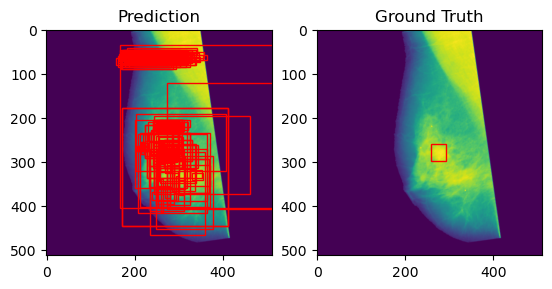

In [32]:
from plotting import plot_image
import matplotlib.patches as patches
idx = 0

img = imgs[idx].cpu().data
c, h, w, = img.shape

fig, axs = plt.subplots(1,2)
axs[0].imshow(img.permute(1,2,0))
axs[0].set_title('Prediction')
for box in preds[idx]['boxes'].detach().numpy():
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), (xmax - ymin), (ymax - ymin), linewidth = 1, edgecolor = 'r', facecolor = 'none')
    axs[0].add_patch(rect)

axs[1].imshow(img.permute(1,2,0))
axs[1].set_title('Ground Truth')
for box in annotations[idx]['boxes']:
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), (xmax - ymin), (ymax - ymin), linewidth = 1, edgecolor = 'r', facecolor = 'none')
    axs[1].add_patch(rect)
#plot_image(imgs[idx], annotations[idx])

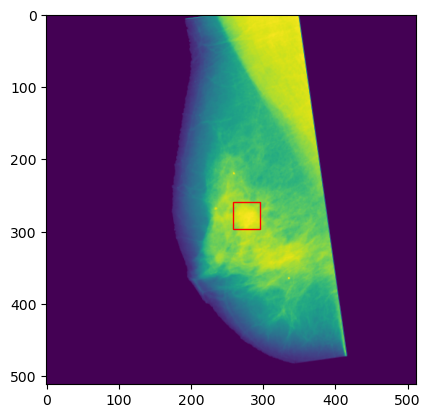

In [28]:
plot_image(imgs[idx], annotations[idx])